# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Библиотеки

In [1]:
!pip install -U scikit-learn -q

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
# библиотеки
from time import time


from sklearn.metrics import mean_squared_error 

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np


from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

## Данные

In [4]:
# загрузка данных
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [5]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


- Столбец **DateCrawled** повторяет дату из столбца **DateCreated**,
он не несёт смысла
- Также столбцы **NumberOfPictures** и **PostalCode** неинформативны
- Столбцы **LastSeen**, **RegistrationMonth** и **DateCreated** тоже удалим

In [6]:
# оставим год скачивания для дальнейшей фильтрации, потом удалим этот столбец
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['YearCrawled'] = data['DateCrawled'].dt.year

In [7]:
# удалим неинформативные столбцы
data = data.drop(['DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated', 'RegistrationMonth'], axis=1)

In [8]:
# посмотрим на размех данных
data.shape

(354369, 11)

In [9]:
# посмотрим на распределение данных
#sns.pairplot(data.select_dtypes(include=['number']))
#plt.show()

## Подготовка данных

In [10]:
# создадим копию основного датафрейма
df = data.copy()

In [11]:
# проверим типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
 10  YearCrawled       354369 non-null  int32 
dtypes: int32(1), int64(4), object(6)
memory usage: 28.4+ MB


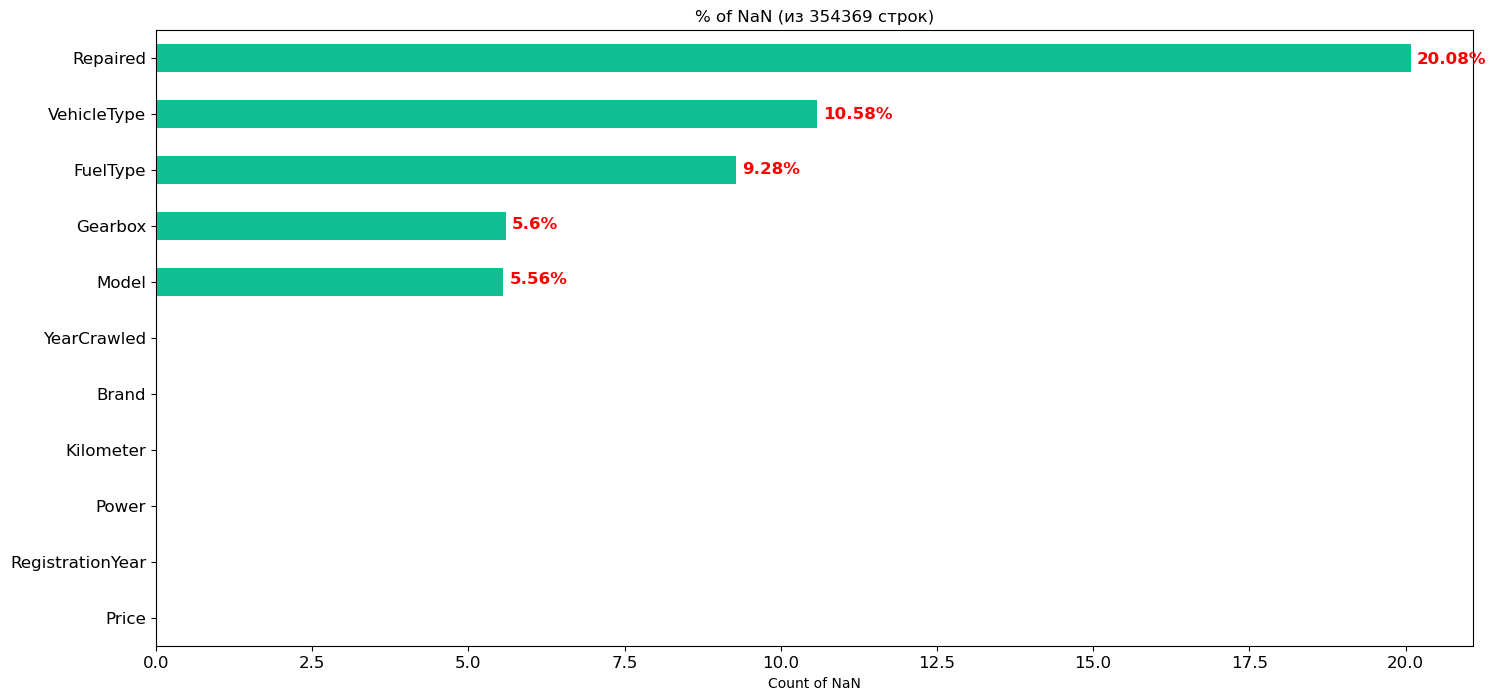

In [12]:
# создадим функцию для проверки процента пропусков по столбцам
def percent_hbar(df, old_threshold=None):
    percent_of_nulls = (df.isnull().sum()/len(df)*100).sort_values().round(2)
    threshold = percent_of_nulls.mean()
    ax = percent_of_nulls.plot(kind='barh', figsize=(17, 8), title='% of NaN (из {} строк)'.format(len(df)), 
                               color='#10bf92', legend=False, fontsize=12)
    ax.set_xlabel('Count of NaN')
    dict_percent = dict(percent_of_nulls)
    i = 0
    for k in dict_percent:
        color = 'blue'
        if dict_percent[k] > 0:
            if dict_percent[k] > threshold:
                color = 'red'
            ax.text(dict_percent[k]+0.1, i + 0.09, str(dict_percent[k])+'%', color=color, 
                    fontweight='bold', fontsize='large')
        i += 0.98
    if old_threshold is not None:
        plt.axvline(x=old_threshold,linewidth=1, color='r', linestyle='--')
        ax.text(old_threshold+0.3, 10, '{0:.2%}'.format(old_threshold/100), color='r', fontweight='bold', fontsize='large')
        plt.axvline(x=threshold,linewidth=1, color='green', linestyle='--')
        ax.text(threshold+0.3, 7, '{0:.2%}'.format(threshold/100), color='green', fontweight='bold', fontsize='large')

    return ax, threshold

plot, threshold = percent_hbar(data)

In [13]:
# Функция для заполнения пропущенных значений наиболее часто встречающимся типом в каждой группе
def fill_most_common(group):
    return group.fillna(group.mode().iloc[0])

# Функция для выбора столбца и применения функции заполнения пропущенных значений
def filling(column_name):
    data[column_name] = data.groupby('Model')[column_name].transform(fill_most_common)

In [14]:
# заполним пропущенные значения в 'VehicleType'
filling('VehicleType')

In [15]:
# рассчитаем новый процент прощенных значений в 'VehicleType' после заполнения пропусков
round((data['VehicleType'].isna().sum() / len(data['VehicleType'])) * 100, 2)

5.56

- теперь процент пропущенных значений в столбце 'VehicleType' около 5.5% значит их можно удалить
- пропущенные значения остались т.к. некоторые значения в 'Model' были пропущены

In [16]:
data = data.dropna(subset=['VehicleType', 'Model'])

In [17]:
# заполним пропущенные значения в 'FuelType' и 'Gearbox'
filling('FuelType')
filling('Gearbox')

In [18]:
# тут ничего предположить нельзя поэтому пропущенные значения заполним как 'unknown'
data['Repaired'] = data['Repaired'].fillna('unknown')

In [19]:
# проверка
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
YearCrawled         0
dtype: int64

- успешно избавились от пропущенных значений

In [20]:
# проверим значения месяцев
# data['RegistrationMonth'].unique()

- есть и месяц под номер **'0'** и под номером **'1'** - скорее всего в обоих случаях имеется в виду 'январь'

In [21]:
# заменим 0 на 1
# data['RegistrationMonth'] = data['RegistrationMonth'].replace(0, 1)

In [22]:
# проверим дубликаты
data.duplicated().sum()

47466

In [23]:
data = data.drop_duplicates()

### Аномалии

In [24]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,YearCrawled
count,287198.000000,287198.00000,287198.000000,287198.000000,287198.0
mean,4614.997208,2004.08647,112.857499,127306.266060,2016.0
std,4593.260837,74.19102,197.371757,38017.689136,0.0
min,0.000000,1000.00000,0.000000,5000.000000,2016.0
25%,1199.000000,1999.00000,72.000000,125000.000000,2016.0
50%,2950.000000,2003.00000,105.000000,150000.000000,2016.0
75%,6700.000000,2008.00000,143.000000,150000.000000,2016.0
max,20000.000000,9999.00000,20000.000000,150000.000000,2016.0


- данные с ценой и мощностью = 0 явно ошибочные
- также есть аномалия в мощности равная 20 тыс. л.с.
- также 1000-й год регистрации выглядит подозрительно,
    а до года регистрации = 9999 нам ждать ещё более 7000 лет   


In [25]:
num_cols = ['RegistrationYear', 'Power', 'Kilometer', 'Price']

### RegistrationYear

- раритеты до 70-ых годов не акутальны для предсказания моделей ввиду своей редкости

In [26]:
data = data.query('1970 <= RegistrationYear')

- проверим год регистрации по верхней границе 

In [27]:
count = np.where(data['YearCrawled'] < data['RegistrationYear'], 1, 0).sum()

print(count)

11337


- количество приемлимо, значит избавимся от невозможных значений

In [28]:
data = data[data['YearCrawled'] >= data['RegistrationYear']]

In [29]:
# удалим ненужный столбец
data = data.drop(['YearCrawled'], axis = 1)

### Power

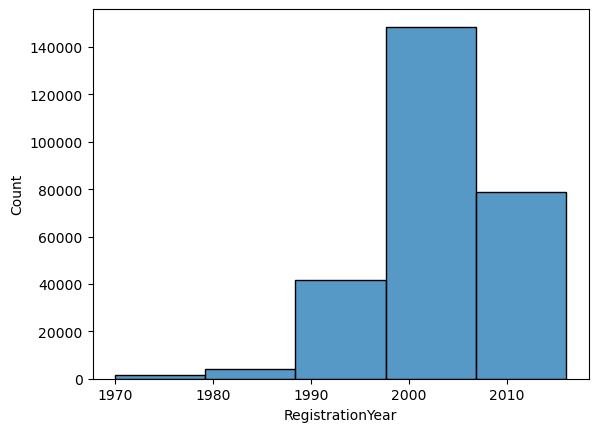

In [30]:
sns.histplot(data['RegistrationYear'], bins=5)
plt.show()

- обычно мощность автомобилей не превышает 1200 - 1500 л.с. и то это большая редкость (у большинства это 200-300 л.с.)
- наш анализ выше показал, что у 75% автомобилей максимальная мощность - 143 л.с.
- учитывая, что максимальная цена в наших данных это 20 тыс.евро, то мощность машин за такую стоимсть вряд ли превысит 600 л.с.

In [31]:
data = data.query('10 < Power <= 600')

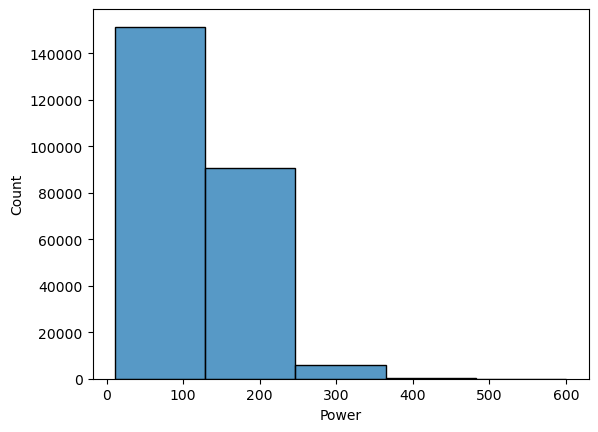

In [32]:
sns.histplot(data['Power'], bins=5)
plt.show()

### Kilometer

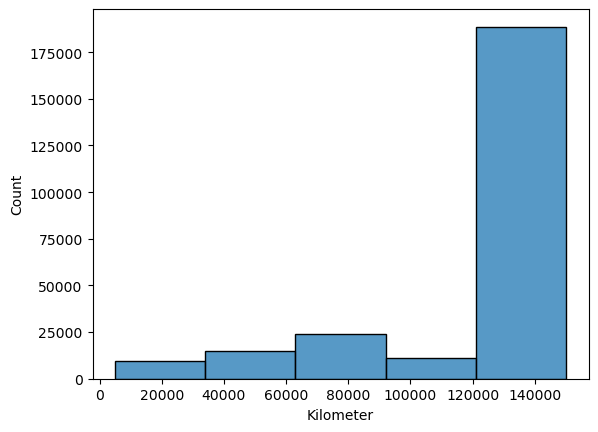

In [33]:
sns.histplot(data['Kilometer'], bins=5)
plt.show()

- у километров аномалий нет

### Price

- купить автомобиль до 500 евро практически невозможно. Самый дешёвый, что я нашёл: Lada (ВАЗ) 2104, 2004 за 50 000 тыс.руб. это как раз около 500 евро

In [34]:
data = data.query('Price >= 500')

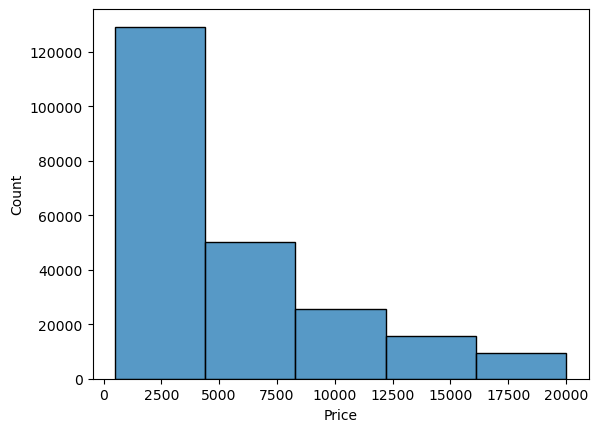

In [35]:
sns.histplot(data['Price'], bins=5)
plt.show()

- цены также распределены адекватно

****

- разобьём данные на тренировочную, валидационную и тестовую выборки 

In [36]:
# целевой признак
y = data['Price']

In [37]:
# удалим целевой признак из общих данных
X = data.drop(['Price'], axis = 1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = 42)

In [39]:
ohe_columns = ['Gearbox', 'FuelType', 'Repaired']
ord_columns = ['VehicleType', 'Model', 'Brand', 'Kilometer']

In [40]:
num_columns = ['RegistrationYear', 'Power']

In [41]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [42]:
ord_pipe = Pipeline(
    [
         (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [43]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [44]:
X_train_processed = pd.DataFrame(data_preprocessor.fit_transform(X_train), columns = data_preprocessor.get_feature_names_out())
X_test_processed = pd.DataFrame(data_preprocessor.transform(X_test), columns = data_preprocessor.get_feature_names_out())

## Обучение моделей

In [45]:
# итоговый пайплайн: подготовка данных и модель
RANDOM_STATE = 42

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state = RANDOM_STATE))
    ]
)

In [46]:
fit = []
predict = []
rmse = []
model = ['DecisionTreeRegressor', 'CatBoost', 'LightGBM']

### DecisionTreeRegressor

In [47]:
params = [
    
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 40),
        'models__min_samples_leaf': range(2, 13),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [48]:
random_1 = RandomizedSearchCV(
    pipe_final, 
    params, 
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
    
)

In [49]:
random_1.fit(X_train, y_train)
random_1.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gearbox', 'FuelType',
                                                   'Repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['VehicleType', 'Model',
                                                   'Brand', 'Kilometer']),
                                                 ('num', RobustScaler(),
                                                  ['RegistrationYear',
                                                   'Power'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=4, max_features=26,
                                       min_samples_leaf=8, random_state=42))])

In [50]:
start = time()
random_1.fit(X_train, y_train)
end = time()
fit.append(end - start)

In [51]:
best_model = random_1.best_estimator_

In [52]:
start = time()
predictions_1 = best_model.predict(X_train)
end = time()
predict.append(end-start)

In [53]:
rmse_tree = (-random_1.best_score_) ** 0.5
rmse.append(rmse_tree)
rmse_tree

2646.392095176481

### CatBoost

In [54]:
for depth in range(3, 10, 3):
    for iterations in range(30, 61, 10):
        gatto = CatBoostRegressor(random_seed=42,
                        loss_function='RMSE',
                        silent=True,
                        iterations = iterations,
                        depth=depth,
                        border_count=None)
        mse = cross_val_score(gatto, X_train_processed, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_2 = (-mse.mean()) ** 0.5
        print(f"RMSE при depth = {depth} и iterations = {iterations}: {rmse_2}")

RMSE при depth = 3 и iterations = 30: 1947.7464562389498
RMSE при depth = 3 и iterations = 40: 1895.305668419465
RMSE при depth = 3 и iterations = 50: 1859.6342474040214
RMSE при depth = 3 и iterations = 60: 1834.38525247748
RMSE при depth = 6 и iterations = 30: 1764.2250273860827
RMSE при depth = 6 и iterations = 40: 1729.7671391836832
RMSE при depth = 6 и iterations = 50: 1706.0589441383574
RMSE при depth = 6 и iterations = 60: 1691.358756062459
RMSE при depth = 9 и iterations = 30: 1683.9788333657873
RMSE при depth = 9 и iterations = 40: 1659.3651578758008
RMSE при depth = 9 и iterations = 50: 1643.2851234859897
RMSE при depth = 9 и iterations = 60: 1631.5320421536762


In [55]:
# лучший показатель RMSE у последней модели
# результат будет уже сохранён в переменную, поэтому сразу добавим её
rmse_gatto = rmse_2
rmse.append(rmse_gatto)

In [56]:
gatto = CatBoostRegressor(random_seed=42,
                        loss_function='RMSE',
                        silent=True,
                        iterations = 60,
                        depth=9,
                        border_count=None)

In [57]:
start = time()
gatto.fit(X_train_processed, y_train)
end = time()
fit.append(end-start)

In [58]:
start = time()
y_pred_2 = gatto.predict(X_train_processed)
end = time()
predict.append(end-start)

### LightGBM

In [59]:
gbm = lgb.LGBMRegressor(boosting_type='gbdt', verbose=0, seed=42)


params = {
    'learning_rate': np.logspace(-5, 0, 5),
    'n_estimators': [30, 5],
    'num_leaves': [20, 30, 40],
}

random_3 = RandomizedSearchCV(gbm,
                        params,
                        cv=3,
                        scoring='neg_mean_squared_error',
                        verbose=True,
                        random_state=RANDOM_STATE)

In [60]:
start = time()
random_3.fit(X_train_processed, y_train)
end = time()
fit.append(end-start)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [61]:
start = time()
y_pred_3 = random_3.best_estimator_.predict(X_train_processed)
end = time()
predict.append(end-start)

In [62]:
mse = cross_val_score(random_3.best_estimator_, X_train_processed, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_gbm = (-mse.mean()) ** 0.5
rmse.append(rmse_gbm)
rmse_gbm

1771.377475545716

## Анализ моделей

### Анализ

In [63]:
table = pd.DataFrame({
    'model': model,
    'fit_time': fit,
    'predict_time': predict,
    'RMSE': rmse
})

table

,model,fit_time,predict_time,RMSE
0,DecisionTreeRegressor,5.092191,0.190829,2646.392095
1,CatBoost,0.566194,0.017965,1631.532042
2,LightGBM,3.301443,0.042334,1771.377476


### Проверка лучшей модели на адекватность

In [64]:
model_dummy = DummyRegressor(strategy="mean")

In [65]:
start = time()
model_dummy.fit(X_train_processed, y_train)
end = time()
print(end - start)

0.00039196014404296875


In [66]:
start = time()
dummy_pred = model_dummy.predict(X_test_processed)
end = time()
print(end - start)

0.0005540847778320312


In [67]:
rmse_dummy = mean_squared_error(y_test, dummy_pred) ** 0.5
print(rmse_dummy)

4647.321765531935


### Вывод

У **CatBoost** значимо лучшие показатели по всем параметрам среди моделей DecisionTreeRegressor и LightGBM. Также видим, что все модели адекватные т.к. их RMSE намного меньше по сравнению с Dummy моделью

In [68]:
# посчитаем rmse для модели СatBoost на тестовых данных
mean_squared_error(y_test, gatto.predict(X_test_processed)) ** 0.5

1643.4000402458619

- результат хороший, модель адекватна